In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#adjust these if your zip files are in a different folder or have different names
DRIVE_TRAIN_ZIP = "/content/drive/MyDrive/asl_alphabet_train.zip"
DRIVE_TEST_ZIP  = "/content/drive/MyDrive/asl_alphabet_test.zip"

#copy from Drive to fast local SSD
!cp "$DRIVE_TRAIN_ZIP" /content/
!cp "$DRIVE_TEST_ZIP" /content/

#unzip into /content
!unzip -q /content/asl_alphabet_train.zip -d /content/
!unzip -q /content/asl_alphabet_test.zip -d /content/

#set train/test directories
ASL_TRAIN_DIR = "/content/asl_alphabet_train"
ASL_TEST_DIR  = "/content/asl_alphabet_test"

import os
print("Train dir exists:", os.path.exists(ASL_TRAIN_DIR))
print("Test dir exists:", os.path.exists(ASL_TEST_DIR))

Train dir exists: True
Test dir exists: True


In [3]:
!nvidia-smi
!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn matplotlib pandas

Fri Dec  5 15:50:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: Tesla T4


In [6]:
from torchvision import transforms

input_size = 224

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),               #small rotations, don’t change sign
    transforms.ColorJitter(
        brightness=0.3, contrast=0.3, saturation=0.3
    ),                                           #lighting / color variation
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1)                     #small shifts in position
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#load full training dataset from /content
full_train = datasets.ImageFolder(root=ASL_TRAIN_DIR, transform=train_transform)
num_classes = len(full_train.classes)
print("Classes:", full_train.classes)
print("Num classes:", num_classes)

#labels for stratified split
try:
    labels = np.array(full_train.targets)
except AttributeError:
    labels = np.array([s[1] for s in full_train.samples])

indices = np.arange(len(full_train))

#required: stratified 80/20 split with seed 429
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=429
)

print("Total images:", len(full_train))
print("Train indices:", len(train_idx))
print("Val indices:", len(val_idx))

#build train/val datasets using ALL images
train_dataset = Subset(full_train, train_idx)

full_train_val = datasets.ImageFolder(root=ASL_TRAIN_DIR, transform=val_test_transform)
val_dataset = Subset(full_train_val, val_idx)

batch_size = 64
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Final train size:", len(train_dataset))
print("Final val size:", len(val_dataset))

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Num classes: 29
Total images: 87000
Train indices: 69600
Val indices: 17400
Final train size: 69600
Final val size: 17400


In [7]:
def set_requires_grad(module, requires_grad: bool):
    for p in module.parameters():
        p.requires_grad = requires_grad

def set_bn_eval(module):
    #force BatchNorm to eval mode to avoid running-stat drift when frozen
    if isinstance(module, nn.BatchNorm2d):
        module.eval()
    for child in module.children():
        set_bn_eval(child)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def build_resnet18(pretrained=True, num_classes=num_classes):
    if pretrained:
        weights = ResNet18_Weights.IMAGENET1K_V1
        model = resnet18(weights=weights)
    else:
        model = resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def freeze_for_TA(model):
    #T-A: freeze entire model except fc (head-only)
    set_requires_grad(model, False)
    set_requires_grad(model.fc, True)
    set_bn_eval(model)

def freeze_for_TB(model):
    #T-B: freeze stem + layer1 + layer2 + layer3; train layer4 + fc
    set_requires_grad(model.conv1, False)
    set_requires_grad(model.bn1, False)
    set_requires_grad(model.layer1, False)
    set_requires_grad(model.layer2, False)
    set_requires_grad(model.layer3, False)

    set_requires_grad(model.layer4, True)
    set_requires_grad(model.fc, True)

    model.conv1.apply(set_bn_eval)
    model.bn1.apply(set_bn_eval)
    model.layer1.apply(set_bn_eval)
    model.layer2.apply(set_bn_eval)
    model.layer3.apply(set_bn_eval)

def freeze_for_TC(model):
    #T-C: progressive — start from T-B and unfreeze layer3 as well
    freeze_for_TB(model)
    set_requires_grad(model.layer3, True)

In [9]:
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = running_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, macro_f1, all_labels, all_preds

In [10]:
def train_model(model, train_loader, val_loader, device, num_epochs=3, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_macro_f1": []
    }

    best_f1 = -1
    best_state = None

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["val_macro_f1"].append(val_f1)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f} Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f} Acc={val_acc:.4f} Macro-F1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history, best_f1

In [11]:
def plot_history(history, title):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(10,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " - Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc", marker="o")
    plt.plot(epochs, history["val_acc"], label="Val Acc", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Training

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


Trainable params T-A: 14877


Epoch 1/3: 100%|██████████| 1088/1088 [05:30<00:00,  3.29it/s]


Epoch 1: Train Loss=1.3536 Acc=0.6684 | Val Loss=0.7463 Acc=0.8071 Macro-F1=0.8063


Epoch 2/3: 100%|██████████| 1088/1088 [05:18<00:00,  3.41it/s]


Epoch 2: Train Loss=0.7202 Acc=0.8015 | Val Loss=0.5411 Acc=0.8495 Macro-F1=0.8497


Epoch 3/3: 100%|██████████| 1088/1088 [05:29<00:00,  3.30it/s]


Epoch 3: Train Loss=0.5983 Acc=0.8261 | Val Loss=0.4879 Acc=0.8549 Macro-F1=0.8564
Best Val Macro-F1 (T-A): 0.8563611310275763


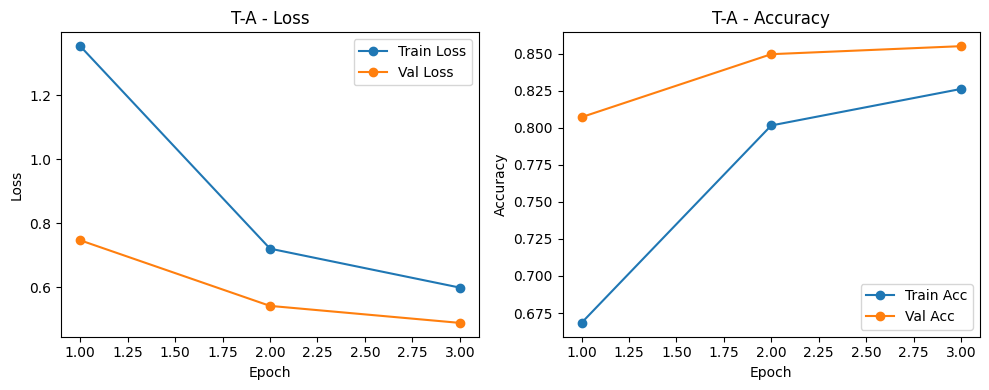

In [12]:
#T-A
model_TA = build_resnet18(pretrained=True, num_classes=num_classes)
freeze_for_TA(model_TA)
print("Trainable params T-A:", count_trainable_params(model_TA))

model_TA, history_TA, best_f1_TA = train_model(
    model_TA, train_loader, val_loader, device, num_epochs=3, lr=1e-3
)

torch.save(model_TA.state_dict(), "best_TA.pth")
print("Best Val Macro-F1 (T-A):", best_f1_TA)
plot_history(history_TA, "T-A")

In [13]:
import shutil

SAVE_DIR = "/content/drive/MyDrive/asl_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

for fname in ["best_TA.pth"]:
    if os.path.exists(fname):
        shutil.copy(fname, os.path.join(SAVE_DIR, fname))
        print(f"Copied {fname} to Drive ✔")
    else:
        print(f"WARNING: {fname} not found")

Copied best_TA.pth to Drive ✔


Trainable params T-B: 8408605


Epoch 1/3: 100%|██████████| 1088/1088 [05:26<00:00,  3.34it/s]


Epoch 1: Train Loss=0.1175 Acc=0.9658 | Val Loss=0.0170 Acc=0.9944 Macro-F1=0.9944


Epoch 2/3: 100%|██████████| 1088/1088 [05:19<00:00,  3.40it/s]


Epoch 2: Train Loss=0.0297 Acc=0.9909 | Val Loss=0.0242 Acc=0.9927 Macro-F1=0.9927


Epoch 3/3: 100%|██████████| 1088/1088 [05:18<00:00,  3.42it/s]


Epoch 3: Train Loss=0.0249 Acc=0.9921 | Val Loss=0.0115 Acc=0.9956 Macro-F1=0.9956
Best Val Macro-F1 (T-B): 0.9956450282507221


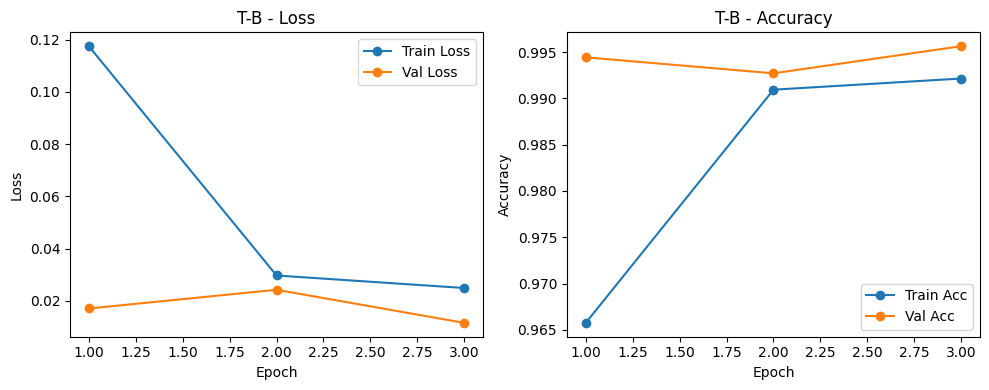

In [14]:
#T-B
model_TB = build_resnet18(pretrained=True, num_classes=num_classes)
freeze_for_TB(model_TB)
print("Trainable params T-B:", count_trainable_params(model_TB))

model_TB, history_TB, best_f1_TB = train_model(
    model_TB, train_loader, val_loader, device, num_epochs=3, lr=1e-3
)

torch.save(model_TB.state_dict(), "best_TB.pth")
print("Best Val Macro-F1 (T-B):", best_f1_TB)
plot_history(history_TB, "T-B")

In [15]:
SAVE_DIR = "/content/drive/MyDrive/asl_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

for fname in ["best_TB.pth"]:
    if os.path.exists(fname):
        shutil.copy(fname, os.path.join(SAVE_DIR, fname))
        print(f"Copied {fname} to Drive ✔")
    else:
        print(f"WARNING: {fname} not found")

Copied best_TB.pth to Drive ✔


Trainable params T-C: 10508317


Epoch 1/3: 100%|██████████| 1088/1088 [05:27<00:00,  3.32it/s]


Epoch 1: Train Loss=0.0275 Acc=0.9913 | Val Loss=0.0143 Acc=0.9961 Macro-F1=0.9961


Epoch 2/3: 100%|██████████| 1088/1088 [05:26<00:00,  3.34it/s]


Epoch 2: Train Loss=0.0157 Acc=0.9951 | Val Loss=0.0077 Acc=0.9980 Macro-F1=0.9980


Epoch 3/3: 100%|██████████| 1088/1088 [05:27<00:00,  3.32it/s]


Epoch 3: Train Loss=0.0100 Acc=0.9969 | Val Loss=0.0162 Acc=0.9957 Macro-F1=0.9957
Best Val Macro-F1 (T-C): 0.998045435004125


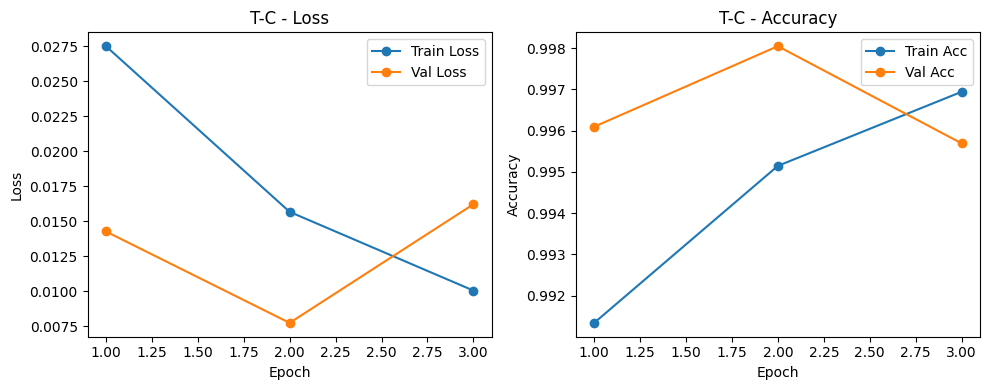

In [16]:
# T-C
model_TC = build_resnet18(pretrained=True, num_classes=num_classes)
model_TC.load_state_dict(torch.load("best_TB.pth", map_location=device))

freeze_for_TC(model_TC)
print("Trainable params T-C:", count_trainable_params(model_TC))

model_TC, history_TC, best_f1_TC = train_model(
    model_TC, train_loader, val_loader, device, num_epochs=3, lr=5e-4
)

torch.save(model_TC.state_dict(), "best_TC.pth")
print("Best Val Macro-F1 (T-C):", best_f1_TC)
plot_history(history_TC, "T-C")

In [17]:
SAVE_DIR = "/content/drive/MyDrive/asl_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

for fname in ["best_TC.pth"]:
    if os.path.exists(fname):
        shutil.copy(fname, os.path.join(SAVE_DIR, fname))
        print(f"Copied {fname} to Drive ✔")
    else:
        print(f"WARNING: {fname} not found")

Copied best_TC.pth to Drive ✔


Trainable params S-A: 11191389


Epoch 1/5: 100%|██████████| 1088/1088 [06:03<00:00,  2.99it/s]


Epoch 1: Train Loss=0.6902 Acc=0.7860 | Val Loss=0.1704 Acc=0.9422 Macro-F1=0.9424


Epoch 2/5: 100%|██████████| 1088/1088 [06:01<00:00,  3.01it/s]


Epoch 2: Train Loss=0.0906 Acc=0.9713 | Val Loss=0.0400 Acc=0.9875 Macro-F1=0.9875


Epoch 3/5: 100%|██████████| 1088/1088 [06:02<00:00,  3.00it/s]


Epoch 3: Train Loss=0.0594 Acc=0.9810 | Val Loss=0.1111 Acc=0.9684 Macro-F1=0.9679


Epoch 4/5: 100%|██████████| 1088/1088 [06:03<00:00,  2.99it/s]


Epoch 4: Train Loss=0.0404 Acc=0.9868 | Val Loss=0.0660 Acc=0.9775 Macro-F1=0.9776


Epoch 5/5: 100%|██████████| 1088/1088 [06:05<00:00,  2.98it/s]


Epoch 5: Train Loss=0.0371 Acc=0.9881 | Val Loss=0.0315 Acc=0.9902 Macro-F1=0.9902
Best Val Macro-F1 (S-A): 0.9901964498434662


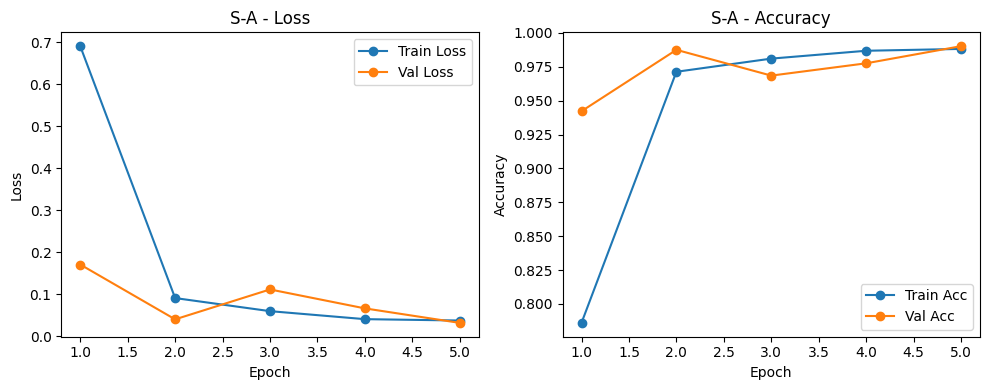

In [18]:
# S-A: train ResNet-18 from scratch
model_SA = build_resnet18(pretrained=False, num_classes=num_classes)
set_requires_grad(model_SA, True)
print("Trainable params S-A:", count_trainable_params(model_SA))

model_SA, history_SA, best_f1_SA = train_model(
    model_SA, train_loader, val_loader, device, num_epochs=5, lr=1e-3
)

torch.save(model_SA.state_dict(), "best_SA.pth")
print("Best Val Macro-F1 (S-A):", best_f1_SA)
plot_history(history_SA, "S-A")

In [19]:
import shutil
SAVE_DIR = "/content/drive/MyDrive/asl_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

for fname in ["best_SA.pth"]:
    if os.path.exists(fname):
        shutil.copy(fname, os.path.join(SAVE_DIR, fname))
        print(f"Copied {fname} to Drive ✔")
    else:
        print(f"WARNING: {fname} not found")

Copied best_SA.pth to Drive ✔


In [20]:
ablation_summary = pd.DataFrame({
    "Model": ["T-A (Head-only)", "T-B (Last block + head)", "T-C (Layer3+4+head)", "S-A (Scratch)"],
    "Best Val Macro-F1": [best_f1_TA, best_f1_TB, best_f1_TC, best_f1_SA]
})
ablation_summary

,Model,Best Val Macro-F1
0,T-A (Head-only),0.856361
1,T-B (Last block + head),0.995645
2,T-C (Layer3+4+head),0.998045
3,S-A (Scratch),0.990196


In [21]:
scores = {
    "T-A": best_f1_TA,
    "T-B": best_f1_TB,
    "T-C": best_f1_TC,
    "S-A": best_f1_SA
}
scores

best_name = max(scores, key=scores.get)
print("Best model by Val Macro-F1:", best_name)

Best model by Val Macro-F1: T-C


In [24]:
#load best model
from google.colab import drive
drive.mount('/content/drive')

best_model_path = "/content/drive/MyDrive/asl_checkpoints/best_TC.pth"

# Rebuild architecture (pretrained=False because we overwrite everything)
best_model = build_resnet18(pretrained=False, num_classes=num_classes)

# Load weights
state_dict = torch.load(best_model_path, map_location=device)
best_model.load_state_dict(state_dict)

best_model.to(device)
best_model.eval()

print("Loaded best model (T-C) successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded best model (T-C) successfully!


In [25]:
import os, shutil

root = "/content/asl_alphabet_test"

for fname in os.listdir(root):
    fpath = os.path.join(root, fname)
    if not os.path.isfile(fpath):
        continue
    # adjust this if your naming is different
    label = fname[0]  # e.g., 'A' from 'A_01.png'
    class_dir = os.path.join(root, label)
    os.makedirs(class_dir, exist_ok=True)
    shutil.move(fpath, os.path.join(class_dir, fname))

# Now ImageFolder will see class folders A, B, etc.
test_dataset = datasets.ImageFolder(root=root, transform=val_test_transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [26]:
# OFFICIAL TEST SET (28 IMAGES)
test_dataset = datasets.ImageFolder(
    root=ASL_TEST_DIR,
    transform=val_test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print("Official test size:", len(test_dataset))
print("Test classes:", test_dataset.classes)

Official test size: 28
Test classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'n', 's']


In [27]:
test_loss, test_acc, test_macro_f1, test_labels, test_preds = evaluate(
    best_model,
    test_loader,
    device
)

print("----- OFFICIAL TEST SET RESULTS -----")
print("Loss:", test_loss)
print("Accuracy:", test_acc)
print("Macro-F1:", test_macro_f1)

from sklearn.metrics import confusion_matrix
test_cm = confusion_matrix(test_labels, test_preds)
test_cm

----- OFFICIAL TEST SET RESULTS -----
Loss: 3.6528055667877197
Accuracy: 0.9285714285714286
Macro-F1: 0.896551724137931


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

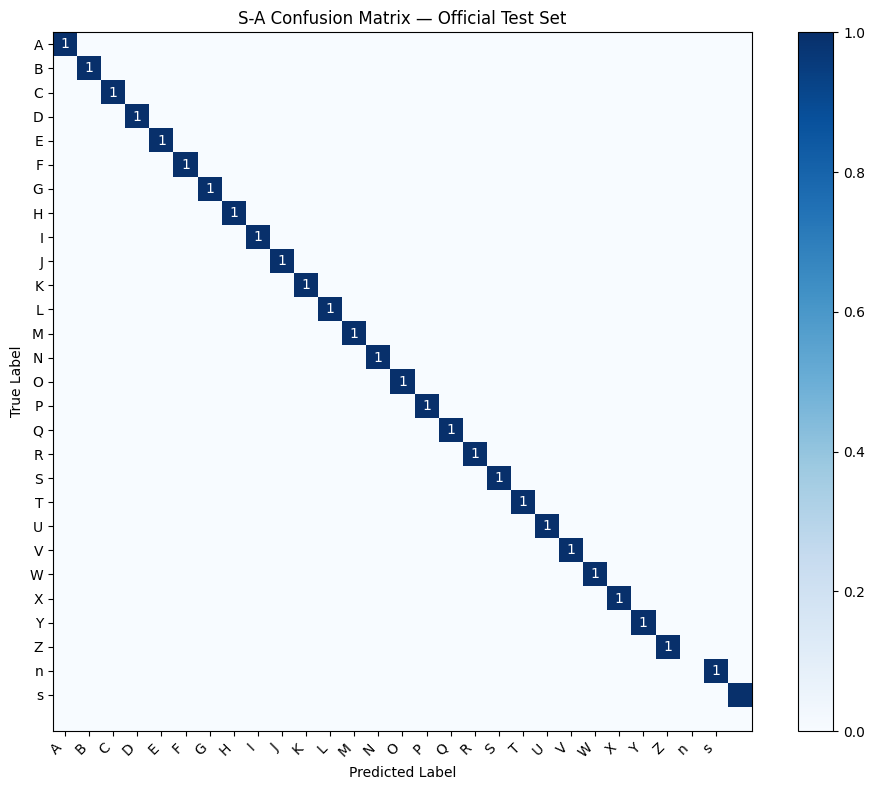

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Normalize rows
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_norm = cm.astype("float") / np.maximum(cm_sum, 1)

    im = ax.imshow(cm_norm, cmap="Blues")
    fig.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))

    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

    # Annotate non-zero values
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] != 0:
                ax.text(j, i, cm[i, j], ha='center', va='center',
                        color="white" if cm_norm[i, j] > 0.5 else "black")

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_cm, test_dataset.classes, title="S-A Confusion Matrix — Official Test Set")

In [29]:
DRIVE_NEW_TEST_ZIP = "/content/drive/MyDrive/my_new_test.zip"

# Copy to /content
!cp "$DRIVE_NEW_TEST_ZIP" /content/

# Unzip
!unzip -q /content/my_new_test.zip -d /content/

MY_TEST_DIR = "/content/my_new_test"  # adjust if needed

!ls -R /content/my_new_test

/content/my_new_test:
A  B  C  D  E  F  G  H	I  K  L

/content/my_new_test/A:
A1.JPEG  A2.JPEG

/content/my_new_test/B:
B1.JPEG  B2.JPEG

/content/my_new_test/C:
C1.JPEG  C2.JPEG

/content/my_new_test/D:
D1.JPEG  D2.JPEG

/content/my_new_test/E:
E1.JPEG  E2.JPEG

/content/my_new_test/F:
F1.JPEG  F2.JPEG

/content/my_new_test/G:
G1.JPEG  G2.JPEG

/content/my_new_test/H:
H1.JPEG  H2.JPEG

/content/my_new_test/I:
I1.JPEG  I2.JPEG

/content/my_new_test/K:
K1.JPEG  K2.JPEG

/content/my_new_test/L:
L1.JPEG  L2.JPEG


In [30]:
my_test_dataset = datasets.ImageFolder(
    root=MY_TEST_DIR,
    transform=val_test_transform
)

my_test_loader = DataLoader(
    my_test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

print("New test size:", len(my_test_dataset))
print("New test classes:", my_test_dataset.classes)

New test size: 22
New test classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L']


In [31]:
my_loss, my_acc, my_macro_f1, my_labels, my_preds = evaluate(
    best_model,
    my_test_loader,
    device
)

print("----- NEW CUSTOM TEST SET RESULTS -----")
print("Loss:", my_loss)
print("Accuracy:", my_acc)
print("Macro-F1:", my_macro_f1)

my_cm = confusion_matrix(my_labels, my_preds)
my_cm

----- NEW CUSTOM TEST SET RESULTS -----
Loss: 5.0864434675736865
Accuracy: 0.6363636363636364
Macro-F1: 0.4880952380952381


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

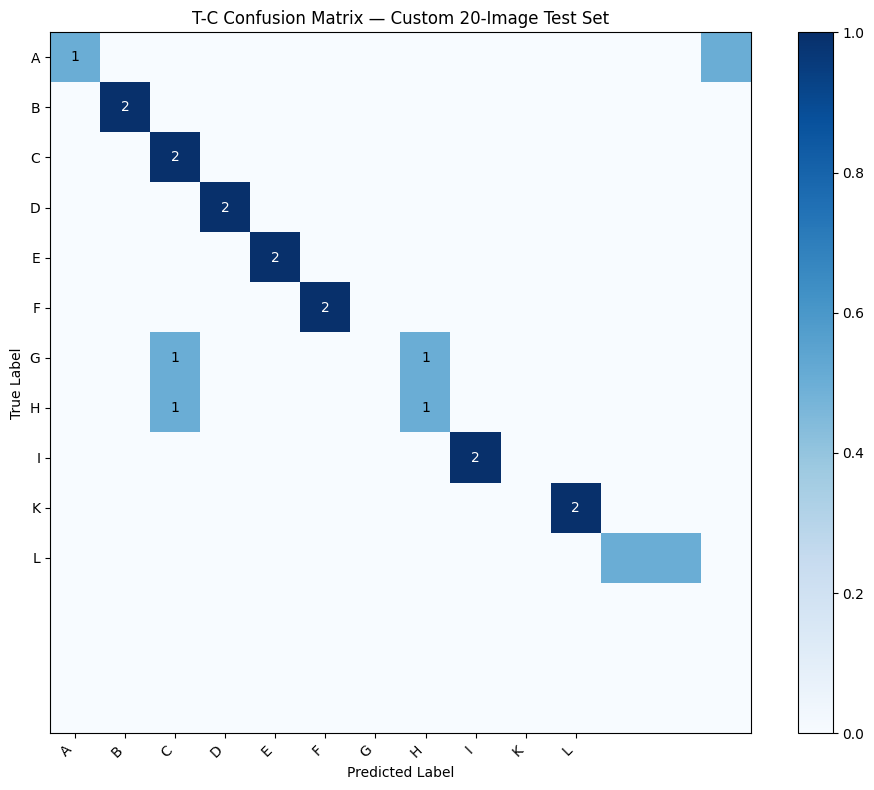

In [32]:
plot_confusion_matrix(my_cm, my_test_dataset.classes,title="T-C Confusion Matrix — Custom 20-Image Test Set")